# Clasificación de obras
- En este cuaderno vamos a clasificar las obras según su tipo: misa,villancico,etc. y su autor.

In [1]:
%%capture
!sudo apt install tesseract-ocr

In [2]:
%%capture
!sudo apt-get install tesseract-ocr-spa

In [3]:
%%capture
pip install pytesseract

In [4]:
%%capture
pip install tesseract

In [5]:

import cv2
import sys
import pytesseract
from pytesseract import Output
import argparse
import pickle
import re,string
import random
from unicodedata import normalize
import numpy as np
from matplotlib import pyplot as plt
from statistics import mean,stdev
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
with open("Obras.pickle", "rb") as f:
    Obras = pickle.load(f)
with open("ini_Obras.pickle", "rb") as f:
    ini_Obras = pickle.load(f)

In [ ]:
%%capture
!unzip /content/drive/MyDrive/Fotos.zip

## Implementando las funciones

In [136]:
def bloques(foto):
  img = foto.copy()
  results = pytesseract.image_to_data(img, output_type=Output.DICT)
  L=[[[],[],[],[]] for i in range (0,len(set(results['block_num'])))]
  for i in range (0, len(results['block_num'])):
    if results['text'][i]!='' and results['text'][i]!=' ':
      j= results['block_num'][i]-1
      L[j][0].append(results['left'][i])
      L[j][1].append(results['top'][i])
      L[j][2].append(results['width'][i])
      L[j][3].append(results['height'][i])
  i=0
  for lista in L:
    if lista!=[[],[],[],[]]:
      x=lista[0][0]-10
      y=lista[1][0]-10
      z1=max(lista[0])
      z=z1+ lista[2][lista[0].index(z1)]+10
      w1=max(lista[1])
      w=w1+ lista[3][lista[1].index(w1)]+3
      cv2.rectangle(img, (x, y), (z,w), (0, 0, 255), 2)
      cv2.putText(img, f'bloque {i}', (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    i=i+1
  return img

- **Detectar los pentagramas**

In [137]:
def pentagramas(foto): 
  foto2 = foto.copy()
  (H,W) = foto.shape[:2]
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  tthreshInv = cv2.resize(threshInv,(int(W*25/100),int(H*25/100)))
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      #cv2.drawContours(foto2, [c], -1, (119, 90, 17), 2)
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      cv2.rectangle(foto2, (x, y), (x + w, y + h), (119, 90, 17), 2)
  return foto2

- **Borrar pentagramas**

In [138]:
def pentagramaBlanco(foto):
  (H,W) = foto.shape[:2]
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  tthreshInv = cv2.resize(threshInv,(int(W*25/100),int(H*25/100)))
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      cv2.drawContours(foto, [c], -1, (255, 255, 255), -1)
      (x, y, w, h) = cv2.boundingRect(c)
      cv2.rectangle(foto, (x, y+40), (x + w, y + h-40), (255, 255, 255), -1)
  return foto

- **Detectar texto**

In [139]:
def espacios(str):
  n = len(str)
  return len([str[i] for i in range(0,n) if str[i]==' ']) == n

def sacarTexto(foto): # Esta función es importante ya que debemos ajustar las cosas bien para poder distinguir cada cosa correctamente.
  
  fotografia = foto.copy()
  foto2 = foto.copy()
  fotografia = pentagramaBlanco(fotografia)
  results = pytesseract.image_to_data(fotografia, lang='spa', output_type=Output.DICT)

  (H,W) = fotografia.shape[:2] # Alto y ancho de la imagen

  for i in range(0, len(results["text"])): # Vamos identificando todas las palabras

    # Sacamos las coordenadas de la palabra
	  x = results["left"][i]
	  y = results["top"][i]
	  w = results["width"][i]
	  h = results["height"][i]
	  # sacamos la palabra 
	  text = results["text"][i]
	  conf = int(results["conf"][i])


	  # Esto es para distinguir texto de otras cosas, si el área que ocupa ese objeto es pequeña entonces es una palabra.
	  if conf > 0.15 and 0 < h < 30 and 8 < w < 350 and not(espacios(text)):

		  text = "".join([c if ord(c) < 300 else "" for c in text]).strip()
		  cv2.rectangle(foto2, (x, y), (x + w, y + h), (0, 255, 0), 2) # Rodeamos la palabra
		  cv2.putText(foto2, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.4, (0, 0, 255), 3) # Ponemos arriba la palabra en formato texto.

  return foto2

- **Guardar el texto**

In [140]:
def remove_punctuation(frase):
  char = re.sub('[%s]' % re.escape(string.punctuation.replace('-','')),'',frase)
  char = char.replace('¿','').replace('?','').replace('`','').replace('´','').replace('#','').lower()
  char = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", char), 0, re.I
    )
  char = normalize( 'NFC', char)
  return char


def guardarTexto(texto,foto,pag): # "texto" es un diccionario, le pasamos una "foto" para que almacene el texto de la página "pag"
  foto = pentagramaBlanco(foto)
  results = pytesseract.image_to_data(foto, lang='spa', output_type=Output.DICT)
  dic = {'text' : [], 'left' : [], 'top' : [], 'width' : [], 'height' : []}
  n = len(results['text'])
  for i in range(0,n):
    x = results['left'][i]
    y = results['top'][i]
    h = results['height'][i]
    w = results['width'][i]
    text = results['text'][i]
    conf = int(results['conf'][i])
    if conf > 0.15 and 0 < h < 30 and 8 < w < 350 and not(espacios(remove_punctuation(text))):
      dic['text'].append(remove_punctuation(text))
      dic['left'].append(x)
      dic['top'].append(y)
      dic['height'].append(h)
      dic['width'].append(w)
  texto[pag] = dic

- **Guardar los pentagramas**

In [141]:
def guardarPentagramas(pentagramas,foto,pag): 
  (H,W) = foto.shape[:2]
  P = []
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  tthreshInv = cv2.resize(threshInv,(int(W*25/100),int(H*25/100)))
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      P.append(cv2.boundingRect(c))
  pentagramas[pag] = P

In [142]:
def borrarTexto(foto,numPag):
  n = len(texto[numPag]['text'])
  foto2 = foto.copy()
  for i in range(0,n):
    x = texto[numPag]['left'][i]
    y = texto[numPag]['top'][i]
    h = texto[numPag]['height'][i]
    w = texto[numPag]['width'][i]
    cv2.rectangle(foto2, (x-150, y-2), (x + w + 150, y + h+2), (255, 255, 255), -1)
  return foto2

In [143]:
def esNumero(cadena):
  try:
    int(cadena)
    return True
  except:
    return False

In [144]:
def verPagina(num_obra):
  for cla in ini_Obras:
    if num_obra in ini_Obras[cla]: return cla

## Comenzamos con el proceso
- Vamos a tener en cuenta la estructura del libro. Cada Capítulo tiene una estructura diferente.
- Las posibles estructuras para guardar la información pueden ser:
  - $Obra[i] = \{coordenadas : (x,y,w,h), Autor: nombre, Tipo : tipo de obra, pag : página \}$

  - $Autor[nombre] = \{O_1 : \{coordenadas : (x,y,w,h),Tipo : tipo de obra, pag : página\},...,O_n : etc\}$
  
  - $TipoObra[tipo] = \{O_1 : \{coordenadas : (x,y,w,h),Autor : nombre, pag : página\},...,O_n : etc\}$

- En realidad con hacer una de estas tres estructuras es suficiente ya que se puede ir fácilmente de una a otra sin problema.

In [16]:
tipos = ['Misa','Salmo','Villancico','Magnificat','Lamentación','Himno','Rosario','Responsorio','Motete','Secuencia','Otro']

In [17]:
claves = [pag for pag in ini_Obras]
Pagina = {}
PaginaBlanco = {}
for cla in claves:
  foto = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
  foto = cv2.cvtColor(foto,cv2.COLOR_BGR2RGB)
  Pagina[cla] = foto
  PaginaBlanco[cla] = foto.copy()

In [18]:
Capitulo = {1:list(range(1,24)),2:list(range(25,35)),3:list(range(35,56)),4:list(range(57,69)),5:list(range(69,77)),6:list(range(77,103)),7:list(range(103,112)),8:list(range(113,142)),9:list(range(143,153)),10:list(range(153,181)),11:list(range(181,205)),12:list(range(205,222)),13:list(range(223,247)),14:list(range(247,337)),15:list(range(337,346)),16:list(range(347,384))}

- **Borramos los recuadros de las obras**

In [19]:
for i in range(1,1554):
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    cv2.rectangle(PaginaBlanco[pag+j], (x, y), (x+w,y+h), (255, 255, 255), -1)

- **Mostramos una imagen**

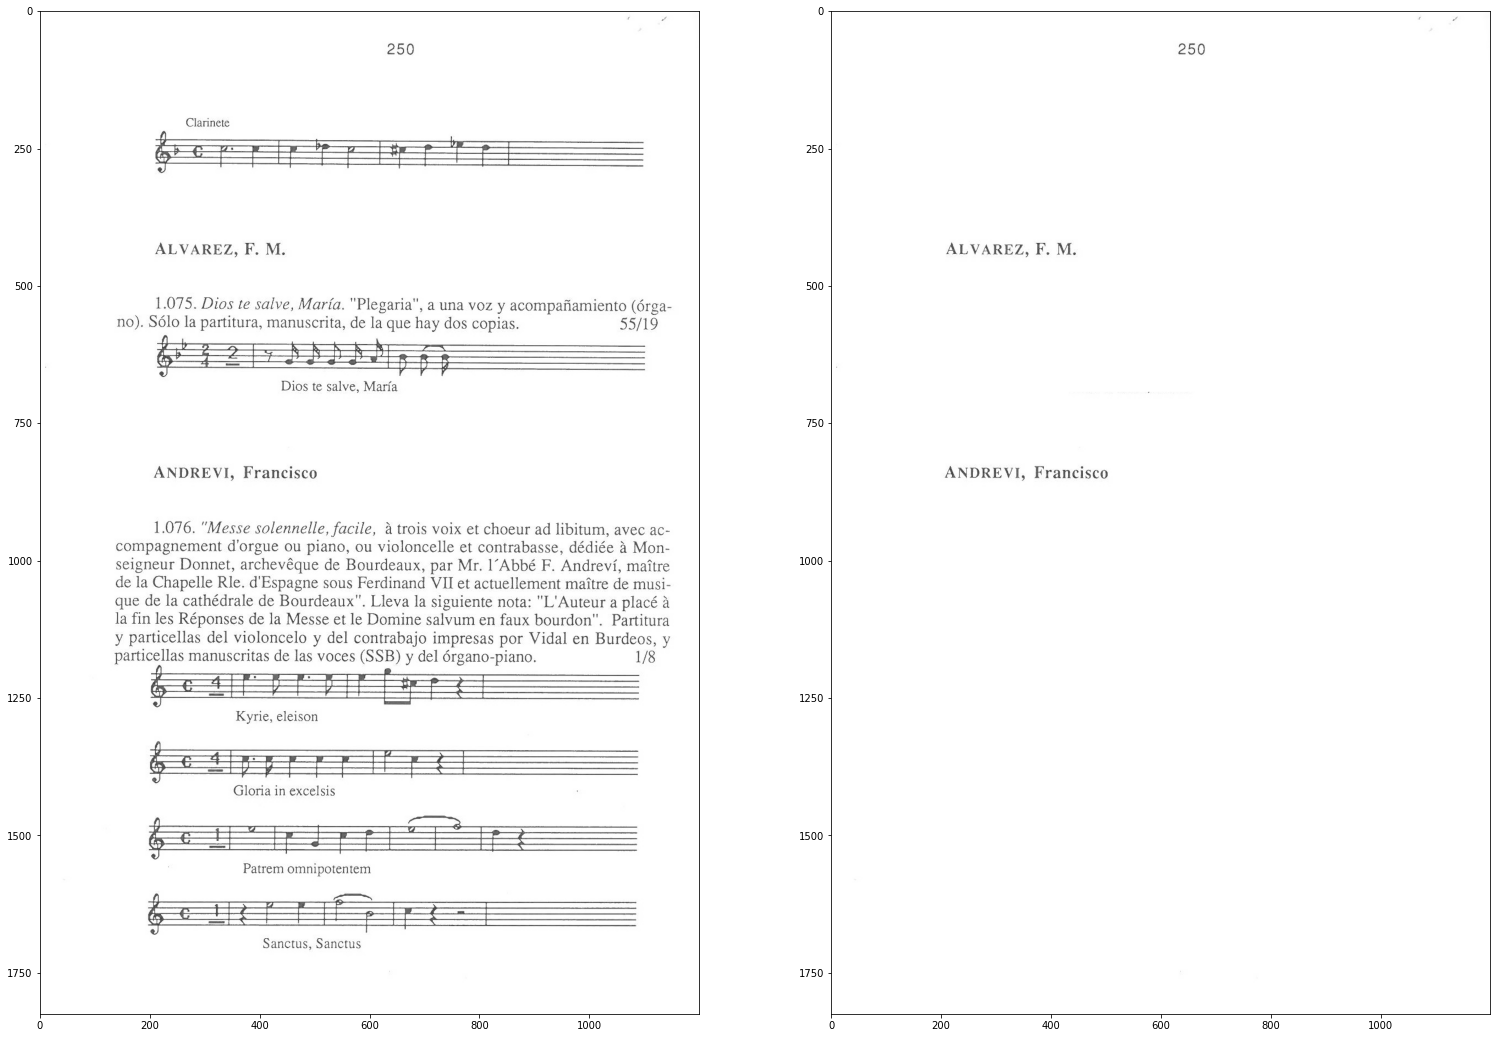

In [20]:
fig, ax = plt.subplots(1,2,figsize=(2*13,2*13))
ax[0].imshow(Pagina[250])
ax[1].imshow(PaginaBlanco[250])
plt.show()

### Nos ayudamos del índice onomástico del libro para guardar el nombre de todos los autores

In [21]:
Fotos = []
for i in range(384,390):
  if i%2 == 0:
    pag = cv2.imread('pag' + str(i+1) + '.jpg')
    pag = cv2.cvtColor(pag, cv2.COLOR_BGR2RGB)
    pag = pag[:1825,175:1375]
    Fotos.append(pag)
  if i%2 == 1:
    pag = cv2.imread('pag' + str(i+1) + '.jpg')
    pag = cv2.cvtColor(pag, cv2.COLOR_BGR2RGB)
    pag = pag[198:,:1200]
    Fotos.append(pag)

In [22]:
def mostrar_Autores(foto):
  foto1 = foto.copy()
  results = pytesseract.image_to_data(foto1, lang='spa', output_type=Output.DICT)
  x1 = results["left"][0]
  y1 = results["top"][0]
  w1 = results["width"][0]
  h1 = results["height"][0]
  texto = results["text"][0]
  for i in range(1,len(results['text'])):
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
    text = results["text"][i]
    conf = int(results["conf"][i])
    if conf > 0.15 and 0 < h < 30 and 8 < w < 350 and not(espacios(text)) and not(esNumero(text[:1])):
      if abs(y1-y) < 10:
        texto = texto + ' ' + text
        w1 = x-x1+w
      else:
        if '(editor):' not in texto.split() and '(editores):' not in texto.split():
          Autores.append(texto)
          cv2.rectangle(foto1, (x1, y1-2), (x1 + w1, y1 + h1 +2), (0, 255, 0), 2)
          cv2.putText(foto1, texto, (600+x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,0.8, (0, 0, 0), 3)
          x1 = results["left"][i]
          y1 = results["top"][i]
          w1 = results["width"][i]
          h1 = results["height"][i]
          texto = results["text"][i]
        else:
          x1 = results["left"][i]
          y1 = results["top"][i]
          w1 = results["width"][i]
          h1 = results["height"][i]
          texto = results["text"][i]          
  if '(editor):' not in texto.split() and '(editores):' not in texto.split():
    Autores.append(texto)
    cv2.rectangle(foto1, (x1, y1-2), (x1 + w1, y1 + h1 +2), (0, 255, 0), 2)
    cv2.putText(foto1, texto, (600+x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,0.8, (0, 0, 0), 3)
    x1 = results["left"][i]
    y1 = results["top"][i]
    w1 = results["width"][i]
    h1 = results["height"][i]
    texto = results["text"][i]
  return foto1

In [23]:
Autores = []

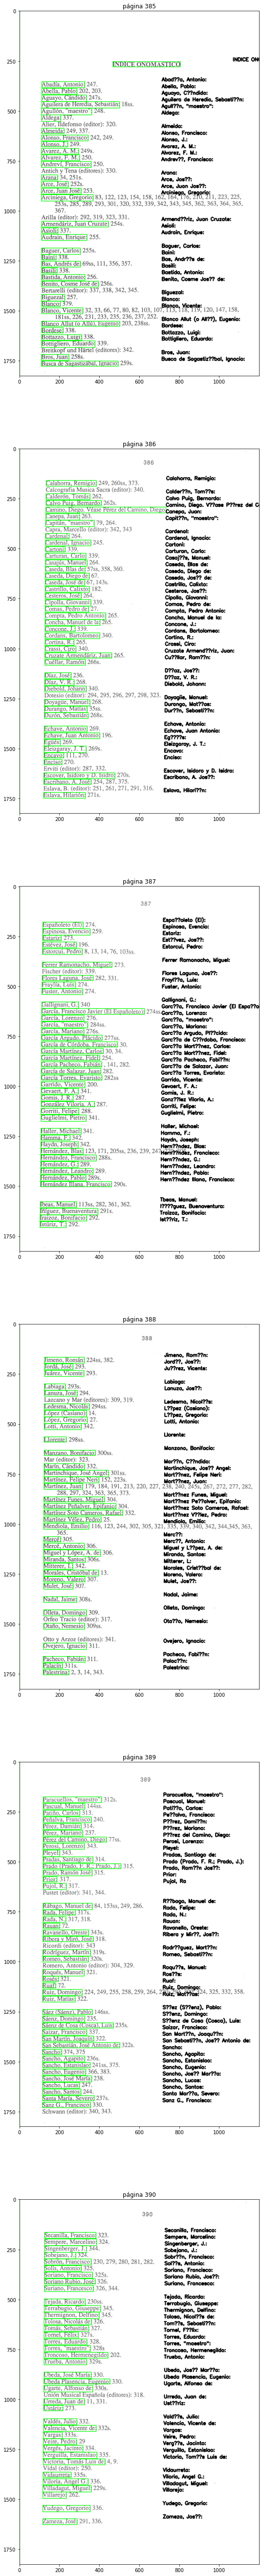

In [24]:
fig, ax = plt.subplots(len(Fotos),1,figsize=(16*len(Fotos),16*len(Fotos)))
for i in range(0,len(Fotos)):
  ax[i].imshow(mostrar_Autores(Fotos[i]),cmap=plt.cm.binary)
  ax[i].set_title('página ' + str(385+i))
plt.show()

In [25]:
Autores = Autores[2:]
print(Autores)

['Abadía, Antonio:', 'Abella, Pablo:', 'Aguayo, Cándido:', 'Aguilera de Heredia, Sebastián:', 'Agullón, "maestro":', 'Aldega:', 'Almeida:', 'Alonso, Francisco:', 'Alonso, J.:', 'Avarez, A. M.:', 'Alvarez, F. M.:', 'Andreví, Francisco:', 'Arana:', 'Arce, José:', 'Arce, Juan José:', 'Arciniega, Gregorio:', 'Armendáriz, Juan Cruzate:', 'Asioli:', 'Audrain, Enrique:', 'Baguer, Carlos:', 'Baini:', 'Bas, Andrés de:', 'Basili:', 'Bastida, Antonio:', 'Benito, Cosme José de:', 'Biguezal:', 'Blanco:', 'Blanco, Vicente:', 'Blanco Allut (o Allú), Eugenio:', 'Bordese:', 'Bottazzo, Luigi:', 'Bottigliero, Eduardo:', 'Bros, Juan:', 'Busca de Sagastizábal, Ignacio:', '', 'Calahorra, Remigio:', 'Calderón, Tomás:', 'Calvo Puig, Bernardo:', 'Camino, Diego. Véase Pérez del Camino, Diego.', 'Canepa, Juan:', 'Capitán, "maestro":', 'Cardenal:', 'Cardenal, Ignacio:', 'Cartoni:', 'Carturan, Carlo:', 'Casajús, Manuel:', 'Caseda, Blas de:', 'Caseda, Diego de:', 'Caseda, José de:', 'Castrillo, Calixto:', 'Cesteros

In [26]:
n = len(Autores)
for i in range(0,n):
  Autores[i]= Autores[i][:-1]

In [27]:
Autores[9] = 'Alvarez, A. M.'

In [28]:
Autores[79] = 'Estariz (¿Ustariz?)'

In [29]:
Autores[69] = 'Egüés'

In [30]:
Autores[64] = 'Doyagüe, Manuel'

In [31]:
Autores[28] = Autores[28][:10] + 'ú' + Autores[28][21:]

In [32]:
Autores[40] = Autores[40][:7]

In [33]:
Autores[164] = 'Prado'

In [34]:
Autores[181] = 'Sáenz (o Sáez), Pablo'

In [35]:
Autores[183] = 'Sáenz de Cosa (o Cosca), Luis'

In [36]:
Autores[113] = 'Ibeas, Manuel'

In [37]:
Autores[115] = 'Iraizoz, Bonifacio'

In [38]:
Autores[29] = 'Bordese, L.'

In [39]:
Autores.append('Amatucci, P.')

In [40]:
Autores.append('Sancho Marraco, José')

In [41]:
Autores.append('Almandoz, Norberto')

In [42]:
Autores.append('Bailon')

- **Por último, será necesario definir una función para encontrar a un autor dentro de un texto**. La mayoría de las veces salen en el libro de dos formas posibles:
  - Apellidos, Nombre
  - Nombre Apellidos

In [43]:
a = 'Apellidos, Nombre'

In [44]:
' '.join(a.split(sep=',')[::-1])

' Nombre Apellidos'

In [45]:
def buscarAutor(autor,text):
  return remove_punctuation(autor) in remove_punctuation(text) or remove_punctuation(' '.join(autor.split(sep=',')[::-1])) in remove_punctuation(text)

In [46]:
Autores[183]

'Sáenz de Cosa (o Cosca), Luis'

In [47]:
text = 'En este texto vamos a buscar a el autor luis saenz de cosa (o cosca) y nada más.'
buscarAutor(Autores[183],text)

True

In [48]:
Obras_final = {}

In [49]:
for a in Autores:
  Obras_final[a] = {}

In [50]:
Obras_final['Anónimo']  = {}

In [51]:
print(Obras_final)

{'Abadía, Antonio': {}, 'Abella, Pablo': {}, 'Aguayo, Cándido': {}, 'Aguilera de Heredia, Sebastián': {}, 'Agullón, "maestro"': {}, 'Aldega': {}, 'Almeida': {}, 'Alonso, Francisco': {}, 'Alonso, J.': {}, 'Alvarez, A. M.': {}, 'Alvarez, F. M.': {}, 'Andreví, Francisco': {}, 'Arana': {}, 'Arce, José': {}, 'Arce, Juan José': {}, 'Arciniega, Gregorio': {}, 'Armendáriz, Juan Cruzate': {}, 'Asioli': {}, 'Audrain, Enrique': {}, 'Baguer, Carlos': {}, 'Baini': {}, 'Bas, Andrés de': {}, 'Basili': {}, 'Bastida, Antonio': {}, 'Benito, Cosme José de': {}, 'Biguezal': {}, 'Blanco': {}, 'Blanco, Vicente': {}, 'Blanco Allú, Eugenio': {}, 'Bordese, L.': {}, 'Bottazzo, Luigi': {}, 'Bottigliero, Eduardo': {}, 'Bros, Juan': {}, 'Busca de Sagastizábal, Ignacio': {}, '': {}, 'Calahorra, Remigio': {}, 'Calderón, Tomás': {}, 'Calvo Puig, Bernardo': {}, 'Camino, Diego. Véase Pérez del Camino, Diego': {}, 'Canepa, Juan': {}, 'Capitán': {}, 'Cardenal': {}, 'Cardenal, Ignacio': {}, 'Cartoni': {}, 'Carturan, Carlo

### Capítulo 1
- Este quizá es el más diferente. Aquí las búsquedas las vamos a hacer haciendo búsquedas dentro de las descripciones de las obras

In [52]:
print(tipos)

['Misa', 'Salmo', 'Villancico', 'Magnificat', 'Lamentación', 'Himno', 'Rosario', 'Responsorio', 'Motete', 'Secuencia', 'Otro']


In [53]:
for i in range(1,63):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Anónimo'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Anónimo'][i]['Tipo'].append(t)
  if 'missa' in text: Obras_final['Anónimo'][i]['Tipo'].append('Misa')
  if 'hymnus' in text: Obras_final['Anónimo'][i]['Tipo'].append('Himno')
  if len(Obras_final['Anónimo'][i]['Tipo']) > 1: Obras_final['Anónimo'][i]['Tipo'] = Obras_final['Anónimo'][i]['Tipo'][1:]

for i in range(63,95):
  pag = verPagina(i)
  Obras_final['Aguilera de Heredia, Sebastián'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Magnificat'], 'pag' : pag}

### Capítulo 2

In [54]:
for i in range(96,101):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Martínez Vélez, Pedro'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Martínez Vélez, Pedro'][i]['Tipo'].append(t)
  if len(Obras_final['Martínez Vélez, Pedro'][i]['Tipo']) > 1: Obras_final['Martínez Vélez, Pedro'][i]['Tipo'] = Obras_final['Martínez Vélez, Pedro'][i]['Tipo'][1:]

for i in range(100,101):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['López, Gregorio'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['López, Gregorio'][i]['Tipo'].append(t)
  if len(Obras_final['López, Gregorio'][i]['Tipo']) > 1: Obras_final['López, Gregorio'][i]['Tipo'] = Obras_final['López, Gregorio'][i]['Tipo'][1:]

for i in range(101,108):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Comas, Pedro de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Comas, Pedro de'][i]['Tipo'].append(t)
  if len(Obras_final['Comas, Pedro de'][i]['Tipo']) > 1: Obras_final['Comas, Pedro de'][i]['Tipo'] = Obras_final['Comas, Pedro de'][i]['Tipo'][1:]

for i in range(108,113):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Veire, Pedro'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Veire, Pedro'][i]['Tipo'].append(t)
  if len(Obras_final['Veire, Pedro'][i]['Tipo']) > 1: Obras_final['Veire, Pedro'][i]['Tipo'] = Obras_final['Veire, Pedro'][i]['Tipo'][1:]

for i in range(113,115):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['García de Córdoba, Francisco'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['García de Córdoba, Francisco'][i]['Tipo'].append(t)
  if len(Obras_final['García de Córdoba, Francisco'][i]['Tipo']) > 1: Obras_final['García de Córdoba, Francisco'][i]['Tipo'] = Obras_final['García de Córdoba, Francisco'][i]['Tipo'][1:]

for i in range(115,134):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['García Martínez, Carlos'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['García Martínez, Carlos'][i]['Tipo'].append(t)
  if len(Obras_final['García Martínez, Carlos'][i]['Tipo']) > 1: Obras_final['García Martínez, Carlos'][i]['Tipo'] = Obras_final['García Martínez, Carlos'][i]['Tipo'][1:]

### Capítulo 3

In [55]:
for i in range(134,143):
  pag = verPagina(i)
  Obras_final['Durango, Matías'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Salmo','Magnificat'], 'pag' : pag}

for i in range(143,146):
  pag = verPagina(i)
  Obras_final['Durango, Matías'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Secuencia'], 'pag' : pag}

for i in range(146,154):
  pag = verPagina(i)
  Obras_final['Durango, Matías'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Himno'], 'pag' : pag}

for i in range(154,234):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Durango, Matías'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Durango, Matías'][i]['Tipo'].append(t)
  if len(Obras_final['Durango, Matías'][i]['Tipo']) > 1: Obras_final['Durango, Matías'][i]['Tipo'] = Obras_final['Durango, Matías'][i]['Tipo'][1:]

### Capítulo 4

In [56]:
for i in range(234,237):
  pag = verPagina(i)
  Obras_final['Caseda, Blas de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Misa'], 'pag' : pag}

for i in range(237,259):
  pag = verPagina(i)
  Obras_final['Caseda, Blas de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Salmo'], 'pag' : pag}

for i in range(259,265):
  pag = verPagina(i)
  Obras_final['Caseda, Blas de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Magnificat'], 'pag' : pag}

for i in range(265,272):
  pag = verPagina(i)
  Obras_final['Caseda, Blas de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Lamentación'], 'pag' : pag}

for i in range(272,283):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Caseda, Blas de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Caseda, Blas de'][i]['Tipo'].append(t)
  if len(Obras_final['Caseda, Blas de'][i]['Tipo']) > 1: Obras_final['Caseda, Blas de'][i]['Tipo'] = Obras_final['Caseda, Blas de'][i]['Tipo'][1:]

### Capítulo 5

In [57]:
for i in range(283,286):
  pag = verPagina(i)
  Obras_final['Bas, Andrés de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Misa'], 'pag' : pag}

for i in range(286,290):
  pag = verPagina(i)
  Obras_final['Bas, Andrés de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Salmo'], 'pag' : pag}

for i in range(290,295):
  pag = verPagina(i)
  Obras_final['Bas, Andrés de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Lamentación'], 'pag' : pag}

for i in range(295,315):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Bas, Andrés de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Bas, Andrés de'][i]['Tipo'].append(t)
  if len(Obras_final['Bas, Andrés de'][i]['Tipo']) > 1: Obras_final['Bas, Andrés de'][i]['Tipo'] = Obras_final['Bas, Andrés de'][i]['Tipo'][1:]

### Capítulo 6

In [58]:
Obras_final['Pérez del Camino, Diego']

{}

In [59]:
for i in range(315,319):
  pag = verPagina(i)
  Obras_final['Pérez del Camino, Diego'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Misa'], 'pag' : pag}

for i in range(319,332):
  pag = verPagina(i)
  Obras_final['Pérez del Camino, Diego'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Salmo','Magnificat'], 'pag' : pag}

for i in range(332,336):
  pag = verPagina(i)
  Obras_final['Pérez del Camino, Diego'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Lamentación'], 'pag' : pag}

for i in range(336,342):
  pag = verPagina(i)
  Obras_final['Pérez del Camino, Diego'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Himno'], 'pag' : pag}

for i in range(342,433):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Pérez del Camino, Diego'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Pérez del Camino, Diego'][i]['Tipo'].append(t)
  if len(Obras_final['Pérez del Camino, Diego'][i]['Tipo']) > 1: Obras_final['Pérez del Camino, Diego'][i]['Tipo'] = Obras_final['Pérez del Camino, Diego'][i]['Tipo'][1:]

### Capítulo 7

In [60]:
Obras_final['Estorcui, Pedro']

{}

In [61]:
for i in range(433,435):
  pag = verPagina(i)
  Obras_final['Estorcui, Pedro'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Misa'], 'pag' : pag}

for i in range(435,451):
  pag = verPagina(i)
  Obras_final['Estorcui, Pedro'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Salmo'], 'pag' : pag}

for i in range(451,454):
  pag = verPagina(i)
  Obras_final['Estorcui, Pedro'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Magnificat'], 'pag' : pag}

for i in range(454,461):
  pag = verPagina(i)
  Obras_final['Estorcui, Pedro'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Lamentación'], 'pag' : pag}

for i in range(461,473):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Estorcui, Pedro'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Estorcui, Pedro'][i]['Tipo'].append(t)
  if len(Obras_final['Estorcui, Pedro'][i]['Tipo']) > 1: Obras_final['Estorcui, Pedro'][i]['Tipo'] = Obras_final['Estorcui, Pedro'][i]['Tipo'][1:]

### Capítulo 8

In [62]:
for i in range(473,477):
  pag = verPagina(i)
  Obras_final['Ibeas, Manuel'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Misa'], 'pag' : pag}

for i in range(477,497):
  pag = verPagina(i)
  Obras_final['Ibeas, Manuel'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Salmo'], 'pag' : pag}

for i in range(497,506):
  pag = verPagina(i)
  Obras_final['Ibeas, Manuel'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Magnificat'], 'pag' : pag}

for i in range(506,516):
  pag = verPagina(i)
  Obras_final['Ibeas, Manuel'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Lamentación'], 'pag' : pag}

for i in range(516,618):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Ibeas, Manuel'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Ibeas, Manuel'][i]['Tipo'].append(t)
  if len(Obras_final['Ibeas, Manuel'][i]['Tipo']) > 1: Obras_final['Ibeas, Manuel'][i]['Tipo'] = Obras_final['Ibeas, Manuel'][i]['Tipo'][1:]

### Capítulo 9

In [63]:
for i in range(618,621):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Caseda, José de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Caseda, José de'][i]['Tipo'].append(t)
  if len(Obras_final['Caseda, José de'][i]['Tipo']) > 1: Obras_final['Caseda, José de'][i]['Tipo'] = Obras_final['Caseda, José de'][i]['Tipo'][1:]

for i in range(621,632):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Pascual, Manuel'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Pascual, Manuel'][i]['Tipo'].append(t)
  if len(Obras_final['Pascual, Manuel'][i]['Tipo']) > 1: Obras_final['Pascual, Manuel'][i]['Tipo'] = Obras_final['Pascual, Manuel'][i]['Tipo'][1:]

for i in range(632,667):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Sáenz (o Sáez), Pablo'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Sáenz (o Sáez), Pablo'][i]['Tipo'].append(t)
  if len(Obras_final['Sáenz (o Sáez), Pablo'][i]['Tipo']) > 1: Obras_final['Sáenz (o Sáez), Pablo'][i]['Tipo'] = Obras_final['Sáenz (o Sáez), Pablo'][i]['Tipo'][1:]

### Capítulo 10

In [64]:
Obras_final['Rábago, Manuel de']

{}

In [65]:
for i in range(667,673):
  pag = verPagina(i)
  Obras_final['Rábago, Manuel de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Misa'], 'pag' : pag}

for i in range(673,689):
  pag = verPagina(i)
  Obras_final['Rábago, Manuel de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Salmo'], 'pag' : pag}

for i in range(689,692):
  pag = verPagina(i)
  Obras_final['Rábago, Manuel de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Magnificat'], 'pag' : pag}

for i in range(692,707):
  pag = verPagina(i)
  Obras_final['Rábago, Manuel de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Lamentación'], 'pag' : pag}

for i in range(707,811):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Rábago, Manuel de'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Rábago, Manuel de'][i]['Tipo'].append(t)
  if len(Obras_final['Rábago, Manuel de'][i]['Tipo']) > 1: Obras_final['Rábago, Manuel de'][i]['Tipo'] = Obras_final['Rábago, Manuel de'][i]['Tipo'][1:]

### Capítulo 11

In [66]:
Obras_final['Blanco, Vicente']

{}

In [67]:
for i in range(811,816):
  pag = verPagina(i)
  Obras_final['Blanco, Vicente'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Misa'], 'pag' : pag}

for i in range(816,829):
  pag = verPagina(i)
  Obras_final['Blanco, Vicente'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Salmo'], 'pag' : pag}

for i in range(829,833):
  pag = verPagina(i)
  Obras_final['Blanco, Vicente'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Magnificat'], 'pag' : pag}

for i in range(833,839):
  pag = verPagina(i)
  Obras_final['Blanco, Vicente'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Responsorio'], 'pag' : pag}

for i in range(839,850):
  pag = verPagina(i)
  Obras_final['Blanco, Vicente'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Lamentación'], 'pag' : pag}

for i in range(850,912):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Blanco, Vicente'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Blanco, Vicente'][i]['Tipo'].append(t)
  if len(Obras_final['Blanco, Vicente'][i]['Tipo']) > 1: Obras_final['Blanco, Vicente'][i]['Tipo'] = Obras_final['Blanco, Vicente'][i]['Tipo'][1:]

### Capítulo 12

In [68]:
Obras_final['Hernández, Blas']

{}

In [69]:
for i in range(912,917):
  pag = verPagina(i)
  Obras_final['Hernández, Blas'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Misa'], 'pag' : pag}

for i in range(917,925):
  pag = verPagina(i)
  Obras_final['Hernández, Blas'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Salmo'], 'pag' : pag}

for i in range(925,932):
  pag = verPagina(i)
  Obras_final['Hernández, Blas'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Magnificat'], 'pag' : pag}

for i in range(932,936):
  pag = verPagina(i)
  Obras_final['Hernández, Blas'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Lamentación'], 'pag' : pag}

for i in range(936,977):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Hernández, Blas'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Hernández, Blas'][i]['Tipo'].append(t)
  if len(Obras_final['Hernández, Blas'][i]['Tipo']) > 1: Obras_final['Hernández, Blas'][i]['Tipo'] = Obras_final['Hernández, Blas'][i]['Tipo'][1:]

### Capítulo 13

In [70]:
Obras_final['Martínez, Felipe Neri']

{}

In [71]:
for i in range(977,980):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Martínez, Felipe Neri'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Martínez, Felipe Neri'][i]['Tipo'].append(t)
  if len(Obras_final['Martínez, Felipe Neri'][i]['Tipo']) > 1: Obras_final['Martínez, Felipe Neri'][i]['Tipo'] = Obras_final['Martínez, Felipe Neri'][i]['Tipo'][1:]

In [72]:
Obras_final['Jimeno, Román']

{}

In [73]:
for i in range(980,998):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Jimeno, Román'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Jimeno, Román'][i]['Tipo'].append(t)
  if len(Obras_final['Jimeno, Román'][i]['Tipo']) > 1: Obras_final['Jimeno, Román'][i]['Tipo'] = Obras_final['Jimeno, Román'][i]['Tipo'][1:]

In [74]:
Obras_final['Villadagut, Miguel']

{}

In [75]:
for i in range(998,1004):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Villadagut, Miguel'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Villadagut, Miguel'][i]['Tipo'].append(t)
  if len(Obras_final['Villadagut, Miguel'][i]['Tipo']) > 1: Obras_final['Villadagut, Miguel'][i]['Tipo'] = Obras_final['Villadagut, Miguel'][i]['Tipo'][1:]

In [76]:
Obras_final['Sobrón, Francisco']

{}

In [77]:
for i in range(1004,1006):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Sobrón, Francisco'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Sobrón, Francisco'][i]['Tipo'].append(t)
  if len(Obras_final['Sobrón, Francisco'][i]['Tipo']) > 1: Obras_final['Sobrón, Francisco'][i]['Tipo'] = Obras_final['Sobrón, Francisco'][i]['Tipo'][1:]

In [78]:
Obras_final['Tejada, Ricardo']

{}

In [79]:
for i in range(1006,1022):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Tejada, Ricardo'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Tejada, Ricardo'][i]['Tipo'].append(t)
  if len(Obras_final['Tejada, Ricardo'][i]['Tipo']) > 1: Obras_final['Tejada, Ricardo'][i]['Tipo'] = Obras_final['Tejada, Ricardo'][i]['Tipo'][1:]

In [80]:
Obras_final['Sáenz, Domingo']

{}

In [81]:
for i in range(1022,1023):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Sáenz, Domingo'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Sáenz, Domingo'][i]['Tipo'].append(t)
  if len(Obras_final['Sáenz, Domingo'][i]['Tipo']) > 1: Obras_final['Sáenz, Domingo'][i]['Tipo'] = Obras_final['Sáenz, Domingo'][i]['Tipo'][1:]

In [82]:
Obras_final['Sáenz de Cosa (o Cosca), Luis']

{}

In [83]:
for i in range(1023,1026):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Sáenz de Cosa (o Cosca), Luis'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Sáenz de Cosa (o Cosca), Luis'][i]['Tipo'].append(t)
  if len(Obras_final['Sáenz de Cosa (o Cosca), Luis'][i]['Tipo']) > 1: Obras_final['Sáenz de Cosa (o Cosca), Luis'][i]['Tipo'] = Obras_final['Sáenz de Cosa (o Cosca), Luis'][i]['Tipo'][1:]

In [84]:
Obras_final['Díaz, José']

{}

In [85]:
for i in range(1026,1028):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Díaz, José'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Díaz, José'][i]['Tipo'].append(t)
  if len(Obras_final['Díaz, José'][i]['Tipo']) > 1: Obras_final['Díaz, José'][i]['Tipo'] = Obras_final['Díaz, José'][i]['Tipo'][1:]

In [86]:
Obras_final['Sancho, Agapito']

{}

In [87]:
for i in range(1028,1032):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Sancho, Agapito'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Sancho, Agapito'][i]['Tipo'].append(t)
  if len(Obras_final['Sancho, Agapito'][i]['Tipo']) > 1: Obras_final['Sancho, Agapito'][i]['Tipo'] = Obras_final['Sancho, Agapito'][i]['Tipo'][1:]

In [88]:
Obras_final['Pérez, Mariano']

{}

In [89]:
for i in range(1032,1033):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Pérez, Mariano'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Pérez, Mariano'][i]['Tipo'].append(t)
  if len(Obras_final['Pérez, Mariano'][i]['Tipo']) > 1: Obras_final['Pérez, Mariano'][i]['Tipo'] = Obras_final['Pérez, Mariano'][i]['Tipo'][1:]

In [90]:
Obras_final['Santa María, Severo']

{}

In [91]:
for i in range(1032,1035):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Santa María, Severo'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Santa María, Severo'][i]['Tipo'].append(t)
  if len(Obras_final['Santa María, Severo'][i]['Tipo']) > 1: Obras_final['Santa María, Severo'][i]['Tipo'] = Obras_final['Santa María, Severo'][i]['Tipo'][1:]

In [92]:
Obras_final['Sancho, José María']

{}

In [93]:
for i in range(1035,1036):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Sancho, José María'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Sancho, José María'][i]['Tipo'].append(t)
  if len(Obras_final['Sancho, José María'][i]['Tipo']) > 1: Obras_final['Sancho, José María'][i]['Tipo'] = Obras_final['Sancho, José María'][i]['Tipo'][1:]

In [94]:
Obras_final['Blanco Allú, Eugenio']

{}

In [95]:
for i in range(1035,1046):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Blanco Allú, Eugenio'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Blanco Allú, Eugenio'][i]['Tipo'].append(t)
  if len(Obras_final['Blanco Allú, Eugenio'][i]['Tipo']) > 1: Obras_final['Blanco Allú, Eugenio'][i]['Tipo'] = Obras_final['Blanco Allú, Eugenio'][i]['Tipo'][1:]

In [96]:
Obras_final['Sancho, Estanislao']

{}

In [97]:
for i in range(1046,1058):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Sancho, Estanislao'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Sancho, Estanislao'][i]['Tipo'].append(t)
  if len(Obras_final['Sancho, Estanislao'][i]['Tipo']) > 1: Obras_final['Sancho, Estanislao'][i]['Tipo'] = Obras_final['Sancho, Estanislao'][i]['Tipo'][1:]

In [98]:
Obras_final['Sancho, Santos']

{}

In [99]:
for i in range(1058,1059):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Sancho, Santos'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Sancho, Santos'][i]['Tipo'].append(t)
  if len(Obras_final['Sancho, Santos'][i]['Tipo']) > 1: Obras_final['Sancho, Santos'][i]['Tipo'] = Obras_final['Sancho, Santos'][i]['Tipo'][1:]

In [100]:
Obras_final['Cardenal, Ignacio']

{}

In [101]:
for i in range(1059,1062):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Cardenal, Ignacio'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Cardenal, Ignacio'][i]['Tipo'].append(t)
  if len(Obras_final['Cardenal, Ignacio'][i]['Tipo']) > 1: Obras_final['Cardenal, Ignacio'][i]['Tipo'] = Obras_final['Cardenal, Ignacio'][i]['Tipo'][1:]

In [102]:
Obras_final['Martínez, Juan']

{}

In [103]:
for i in range(1062,1065):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Martínez, Juan'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Martínez, Juan'][i]['Tipo'].append(t)
  if len(Obras_final['Martínez, Juan'][i]['Tipo']) > 1: Obras_final['Martínez, Juan'][i]['Tipo'] = Obras_final['Martínez, Juan'][i]['Tipo'][1:]

### Capítulo 14 y 15
 - Este capítulo es demasiado tedioso para meter todos los autores a mano así que vamos a intentar ayudarnos de la estructura que tiene. Como el 15 tiene la misma estructura también lo metemos.

In [104]:
Autores2 = [remove_punctuation(a) for a in Autores]
Autores22 = []
for a in Autores:
  if len(a.split(sep=',')) > 1:
    Autores22.append(remove_punctuation(' '.join(a.split(sep=',')[::-1]))[1:])
  else:
    Autores22.append(remove_punctuation(' '.join(a.split(sep=',')[::-1])))

In [105]:
Autores[45],Autores2[45],Autores22[45]

('Casajús, Manuel', 'casajus manuel', 'manuel casajus')

In [106]:
Autores[Autores22.index('manuel casajus')]

'Casajús, Manuel'

In [109]:
Anterior = 'Abadía, Antonio'
for i in range(247,346):
  pag = PaginaBlanco[i].copy()
  foto = pag.copy()
  pag = cv2.cvtColor(pag,cv2.COLOR_RGB2GRAY)
  T,pag = cv2.threshold(pag, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  for j in range(0,5):
    pag = cv2.dilate(pag,(15,15))
  rectKernel=cv2.getStructuringElement(cv2.MORPH_RECT,(100,15))
  pag=cv2.morphologyEx(pag,cv2.MORPH_CLOSE,rectKernel)
  cnts,_ = cv2.findContours(pag, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  Texto = []
  for c in cnts[::-1]:
    x,y,w,h = cv2.boundingRect(c)
    if cv2.contourArea(c) > 1500 and x - 15 > 0:
      text = remove_punctuation(pytesseract.image_to_string(foto[y-15:y+h+15,x-15:x+w+15], lang='spa', output_type=Output.DICT)['text'].replace('\n','').replace('\x0c','').rstrip('  '))
      if text == 'cardenal ': text = 'cardenal'
      if text == 'mitterer 1': text = remove_punctuation('Mitterer, L')
      if text in Autores2 or text in Autores22:
        ya = cv2.boundingRect(c)[1]
        if text in Autores2:
          Autor = Autores[Autores2.index(text)]
          Texto.append((Autor,ya))
        else:
          Autor = Autores[Autores22.index(text)]
          Texto.append((Autor,ya))
  for o in ini_Obras[i]:
    yo = ini_Obras[i][o][1]
    Foto = []
    pag = verPagina(i)
    n = len(Obras[o])
    for j in range(0,n):
      x,y,w,h = Obras[o][j]
      Foto.append(Pagina[i+j][y:y+h,x:x+w])
    Foto = np.concatenate(Foto,axis=0)
    ti = ['Otro']
    text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
    for t in tipos:
      if remove_punctuation(t) in text: ti.append(t)
    if 'missa' in text: ti.append('Misa')
    if len(ti) > 1: ti = ti[1:]
    if len([a[0] for a in Texto if a[1] < yo]) > 0:
      Autor = [a[0] for a in Texto if a[1] < yo][-1]
    else: Autor = Anterior
    Obras_final[Autor][o] = {'Coordenadas' : Obras[o], 'Tipo' : ti, 'pag' : i}
    Anterior = Autor

### Capítulo 16

In [110]:
Obras_final['Anónimo']

{1: {'Coordenadas': [(80, 782, 1080, 179)], 'Tipo': ['Otro'], 'pag': 1},
 2: {'Coordenadas': [(80, 966, 1080, 175)], 'Tipo': ['Otro'], 'pag': 1},
 3: {'Coordenadas': [(80, 1146, 1080, 174)], 'Tipo': ['Otro'], 'pag': 1},
 4: {'Coordenadas': [(80, 1325, 1080, 164)], 'Tipo': ['Otro'], 'pag': 1},
 5: {'Coordenadas': [(80, 124, 1080, 183)], 'Tipo': ['Otro'], 'pag': 2},
 6: {'Coordenadas': [(80, 312, 1080, 850)], 'Tipo': ['Misa'], 'pag': 2},
 7: {'Coordenadas': [(80, 1167, 1080, 382), (80, 196, 1080, 441)],
  'Tipo': ['Misa'],
  'pag': 2},
 8: {'Coordenadas': [(80, 642, 1080, 722)], 'Tipo': ['Misa'], 'pag': 3},
 9: {'Coordenadas': [(80, 157, 1080, 839)], 'Tipo': ['Misa'], 'pag': 4},
 10: {'Coordenadas': [(80, 1001, 1080, 610), (80, 175, 1080, 169)],
  'Tipo': ['Misa'],
  'pag': 4},
 11: {'Coordenadas': [(80, 375, 1080, 784)], 'Tipo': ['Misa'], 'pag': 5},
 12: {'Coordenadas': [(80, 1164, 1080, 473), (80, 118, 1080, 445)],
  'Tipo': ['Misa'],
  'pag': 5},
 13: {'Coordenadas': [(80, 568, 1080, 

In [111]:
for i in range(1384,1400):
  pag = verPagina(i)
  Obras_final['Anónimo'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Misa'], 'pag' : pag}

for i in range(1400,1422):
  pag = verPagina(i)
  Obras_final['Anónimo'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Salmo'], 'pag' : pag}

for i in range(1422,1426):
  pag = verPagina(i)
  Obras_final['Anónimo'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Magnificat'], 'pag' : pag}

for i in range(1426,1434):
  pag = verPagina(i)
  Obras_final['Anónimo'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Lamentación'], 'pag' : pag}

for i in range(1434,1554):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  text = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  Obras_final['Anónimo'][i] = {'Coordenadas' : Obras[i], 'Tipo' : ['Otro'], 'pag' : pag}
  if 'motetes' in text: Obras_final['Anónimo'][i]['Tipo'].append('Motete')
  if 'responso' in text: Obras_final['Anónimo'][i]['Tipo'].append('Responsorio')
  for t in tipos:
    if remove_punctuation(t) in text: Obras_final['Anónimo'][i]['Tipo'].append(t)
  if len(Obras_final['Anónimo'][i]['Tipo']) > 1: Obras_final['Anónimo'][i]['Tipo'] = Obras_final['Anónimo'][i]['Tipo'][1:]

## Guardamos los resultados

In [114]:
with open("Obras_final.pickle", "wb") as f:
    ini_Obras = pickle.dump(Obras_final,f)

- definiendo una pequeña aplicación de búsqueda

In [118]:
Obras_final['Abadía, Antonio']

{1065: {'Coordenadas': [(80, 444, 1080, 255)],
  'Tipo': ['Lamentación'],
  'pag': 247},
 1066: {'Coordenadas': [(80, 704, 1080, 432)], 'Tipo': ['Otro'], 'pag': 247},
 1067: {'Coordenadas': [(80, 1141, 1080, 210)],
  'Tipo': ['Villancico'],
  'pag': 247}}

In [146]:
def buscar(autor):
  if autor not in Obras_final.keys(): print('Ese autor no existe o está mal escrito.')
  else:
    print('Aquí están todas las obras de ' + autor + ':')
    print('')
    for i in Obras_final[autor]:
      Foto = []
      pag = verPagina(i)
      n = len(Obras[i])
      for j in range(0,n):
        x,y,w,h = Obras[i][j]
        Foto.append(Pagina[pag+j][y:y+h,x:x+w])
      Foto = np.concatenate(Foto,axis=0)
      fig, ax = plt.subplots(1,1,figsize=(16,16))
      ax.imshow(Foto,cmap=plt.cm.binary)
      plt.show()

Aquí están todas las obras de Abadía, Antonio:



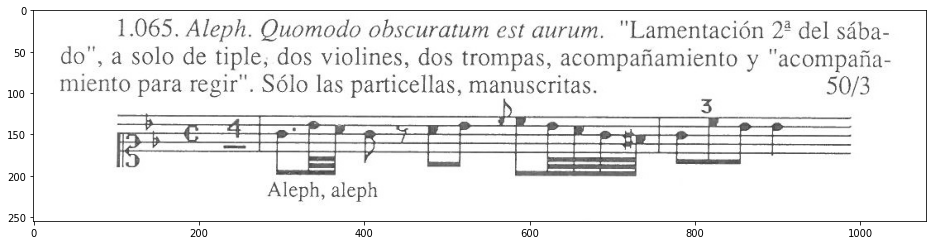

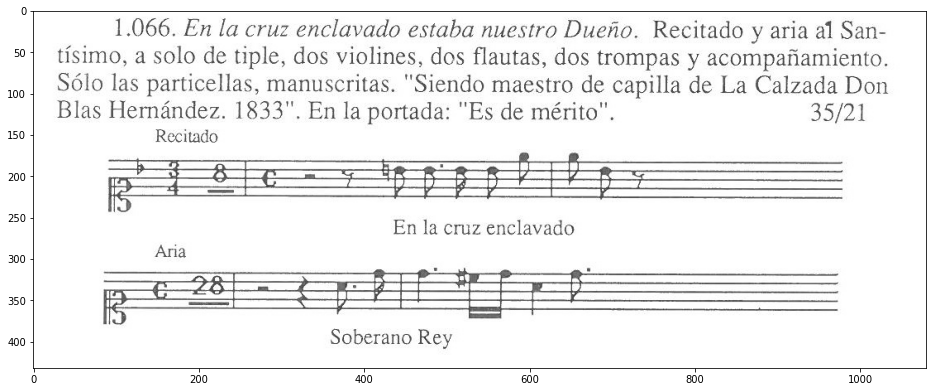

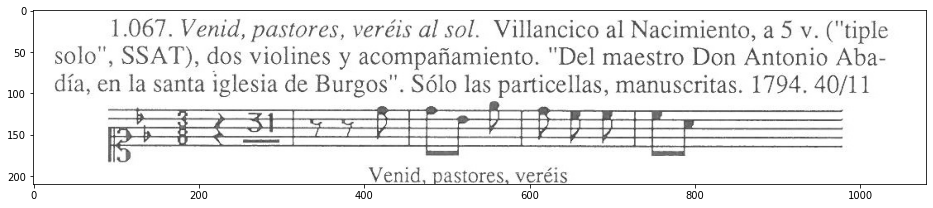

In [147]:
buscar('Abadía, Antonio')